In [1]:
import fnmatch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *
from VIGOR_Figure5_Functions import compute_intercept
from VIGOR_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/sequencesALLDATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [3]:
params = {}
rat_markers = {}
sequence = {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal', 

                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'
               }

intact_map = plt.cm.get_cmap('hsv')
lesion_map = plt.cm.get_cmap('autumn')

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}
c = {'normal': 'silver', 'DLS': 'gold', 'DMS': 'gold'}

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

lesioned = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42',
            'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

rat_example_intact = 'RatM00'
rat_example_lesion = 'RatF52'#'RatF50': # 'RatF52'
for index, animal in enumerate(animalList):
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[c[brainstatus[animal]], 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[c[brainstatus[animal]], 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")


    if animal == rat_example_lesion: 
        rat_markers[animal][0] = 'darkorange'
        rat_markers[animal][1] = '^'

    if animal == rat_example_intact:
        rat_markers[animal][0] = 'dodgerblue'
        rat_markers[animal][1] = '^'

    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
        sequence[animal, session] = get_from_pickle(root, animal, session, name="sequence.p")
        params[animal, session] = get_from_pickle(root, animal, session, name="params.p")

weights = {}
for animal in animalList:
    weights[animal] = []
    for session in matchsession(animal, dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20):
        weights[animal].extend([params[animal, session]['weight']])
    weights[animal] = sum(weights[animal]) / len(weights[animal])
print(weights)


{'RatF00': 212.0212765957447, 'RatF01': 205.85106382978722, 'RatF02': 193.75, 'RatM00': 259.375, 'RatM01': 278.125, 'RatM02': 253.19148936170214, 'RatF30': 204.14893617021278, 'RatF31': 216.875, 'RatF32': 209.58333333333334, 'RatF33': 214.6875, 'RatM30': 224.79166666666666, 'RatM31': 279.5833333333333, 'RatM32': 259.1666666666667, 'RatF40': 196.84782608695653, 'RatF41': 199.44444444444446, 'RatF42': 206.54761904761904, 'RatM40': 238.69565217391303, 'RatM41': 238.19148936170214, 'RatM42': 242.3913043478261, 'RatM43': 262.2340425531915, 'RatF50': 182.70833333333334, 'RatF51': 199.0625, 'RatF52': 174.46808510638297, 'RatM50': 283.6666666666667, 'RatM51': 275.63829787234044, 'RatM52': 265.63829787234044, 'RatM53': 265.4255319148936, 'RatM54': 280.0}


In [4]:
epsilon_0, epsilon_t, epsilon_u, power = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))
alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
median_alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
median_alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
median_alpha_u = {animal: np.median([alpha_u[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_u = {animal: np.median([gamma_u[animal][cond] for cond in conds]) for animal in animalList}
median_mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in animalList}
median_mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in animalList}
median_mu_u = {animal: np.median([mu_u[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_u = {animal: np.median([sigma_u[animal][cond] for cond in conds]) for animal in animalList}

vars = [epsilon_0, epsilon_t, epsilon_u, median_alpha_0, median_alpha_t, median_alpha_u, median_gamma_0, median_gamma_t, median_gamma_u, median_mu_0, median_mu_t, median_mu_u, median_sigma_0, median_sigma_t, median_sigma_u]
names = ['epsilon_0', 'epsilon_t', 'epsilon_u', 'alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']


# S3 correlation alpha_u gamma_u

Observed Slope: 0.5450
P-value: 0.0001


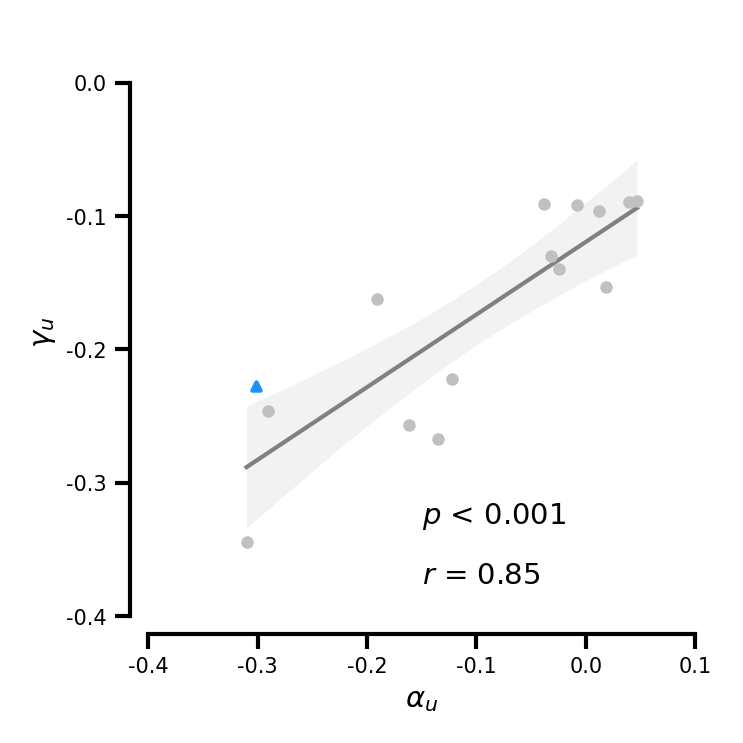

In [5]:
from scipy.optimize import curve_fit

def FigureS3(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            ax.scatter(median_alpha_u[animal], median_gamma_u[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
            x.append(median_alpha_u[animal])
            y.append(median_gamma_u[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(stars(p_value), xy=(.50, .22), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.2f}", xy=(.50, .12), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    ax.set_xlabel(r'$\alpha_u$')
    ax.set_ylabel(r'$\gamma_u$')

    ax.set_xlim(-.4, .1)
    ax.set_ylim(-.4, 0)
    # ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
    space_axes(ax, top_y=.1)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope

# fig, axs = plt.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios': [5, 1]})
# shuffled_slopes, observed_slope = FigureS3(ax=axs[0])
# plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, ylim=[-1, 1], ax=axs[1], ylabel='Slope')

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(6)))
_, _ = FigureS3(ax=ax)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S3.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S3.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

# S2 sum dist sum wat

In [21]:
from scipy.ndimage import gaussian_filter as smooth
from VIGOR_dataProcessing import fixcamglitch, fix_start_session
def get_session_total_dist_and_effort(animal, session):
    '''get the total effort expended in a session in Joules'''
    pos = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    cameraEdit = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[11])[:90000]
     
    pos, cameraEdit = fix_start_session(pos, cameraEdit)
    pos = fixcamglitch(time, pos, cameraEdit)
    pos = smooth(np.array(pos, dtype=float), 2)
    w = weights[animal]/1000
    alpha = 1
    beta = 0

    # correct distance for treadmill speed
    tm_speed = get_from_pickle(root, animal, session, name="params.p")['treadmillSpeed'][0]

    TM1_pfPOS = [16.1, 97.3]
    TM2_pfPOS = [17.2, 98.1]

    D = abs(np.diff(pos)/100)
    correction = np.zeros(len(D))
    for idx, (pos, dist) in enumerate(zip(pos, D)):
        if TM1_pfPOS[0] < pos < TM1_pfPOS[1]:
            dist -= tm_speed/100 * 0.04
            correction[idx] = dist if dist > 0 else 0

    instant_effort = ((alpha * w * (correction ** 2)) / np.diff(time)) + beta * w * np.diff(time)
    # instant_effort = ((alpha * w * (abs(np.diff(pos)/100) ** 2)) / np.diff(time)) + beta * w * np.diff(time)
    instant_effort = np.insert(instant_effort, 0, beta * w * 0.04)


    tot = [0]
    tot.extend(correction)
    totaldist = np.cumsum(tot)
    return totaldist[-1], np.cumsum(instant_effort)[-1]

def get_session_total_drops(sequence):
    totaldrops = 0
    for elem in sequence:
        if sequence[elem][1] == 'run':
            if sequence[elem][2] == 1:
                totaldrops += 1
    return totaldrops


conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
sessionlists = [dist60, dist90, dist120, TM20, TM10, TM2+TMrev2, TMrev10, TMrev20]

if os.path.exists("picklejar/totaldist_totaldrops_totaleffort.p"):
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))
else:
    total_dist_by_animal = {a: {c:[] for c in conds} for a in animalList}
    total_drops_by_animal = {a: {c:[] for c in conds} for a in animalList}
    total_effort_by_animal = {a: {c:[] for c in conds} for a in animalList}

    for jdx, (sessionList, cond) in enumerate(zip(sessionlists, conds)):
        print(cond)
        for idx, animal in enumerate(animalList):
            for session in matchsession(animal, sessionList):
                if not 'L' in session:
                    dist, eff = get_session_total_dist_and_effort(animal, session)
                    drops = get_session_total_drops(sequence[animal, session])

                    total_dist_by_animal[animal][cond].append(dist)
                    total_drops_by_animal[animal][cond].append(drops)
                    total_effort_by_animal[animal][cond].append(eff)

    # pickle.dump([total_dist_by_animal, total_drops_by_animal, total_effort_by_animal], open("picklejar/totaldist_totaldrops_totaleffort.p", "wb"))


/home/david/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


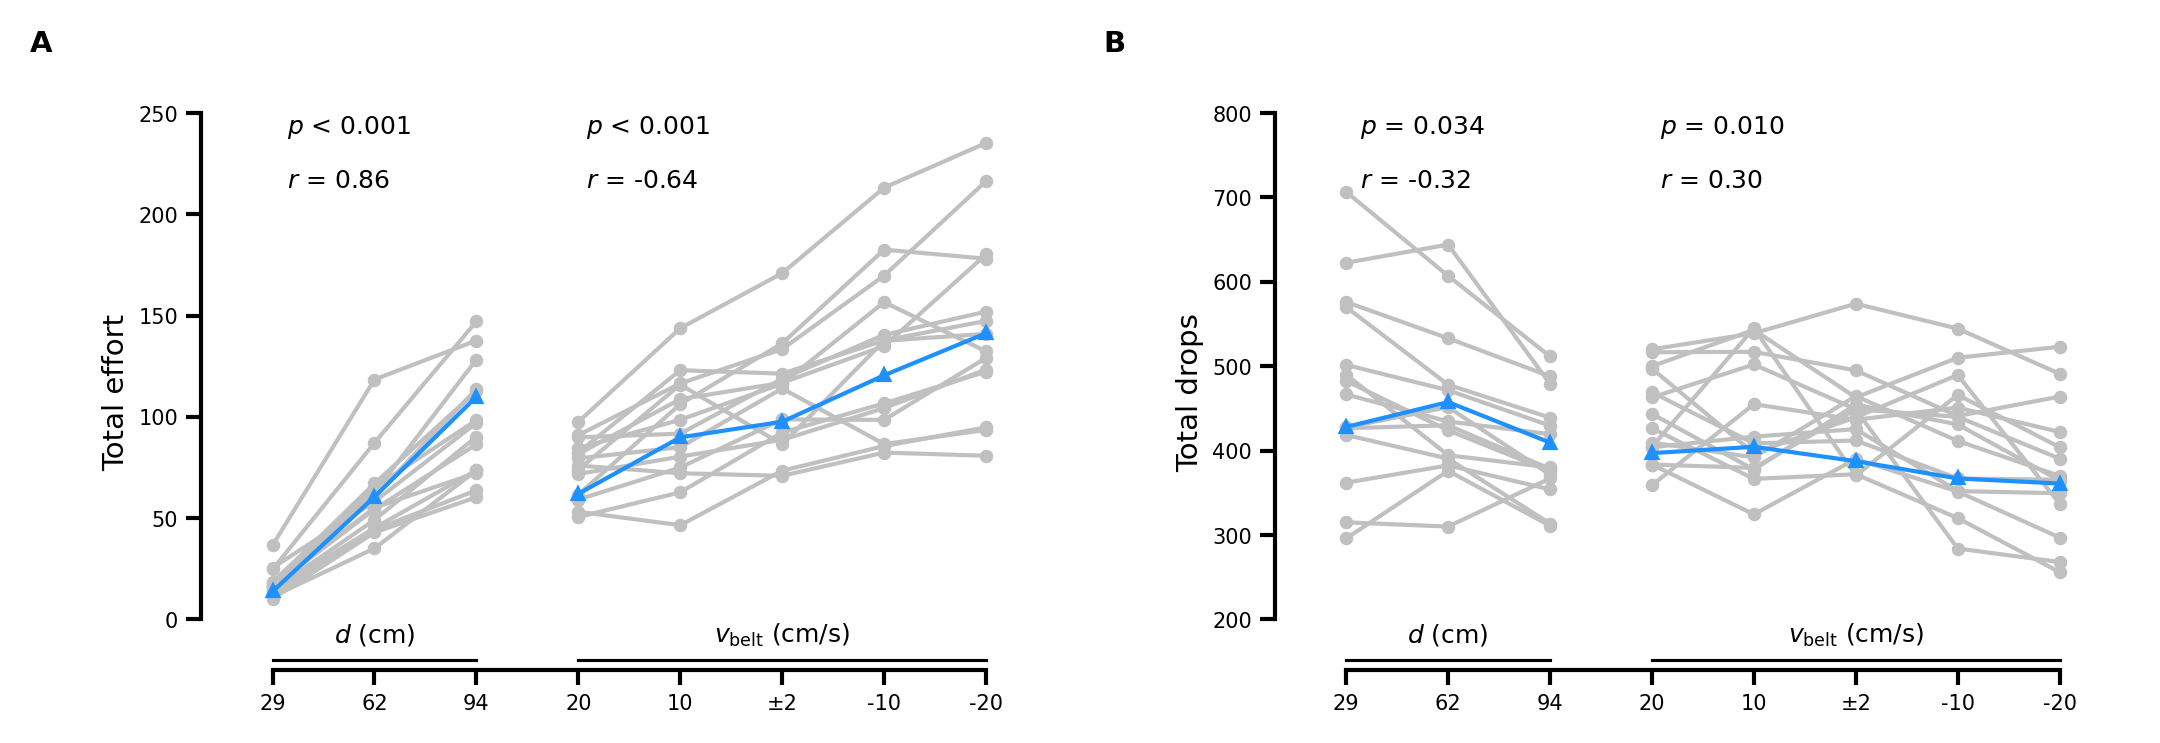

In [22]:
def FigureS2(data, ax=None, ylim=[0, 1000], ylabel='Total'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    x = np.arange(len(conds))

    for animal in intact:
        ydist = np.array([np.median(data[animal][cond]) for cond in ["60", "90", "120"]])
        yTM = np.array([np.median(data[animal][cond]) for cond in ["20", "10", "2", "rev10", "rev20"]])

        zorder = 5 if animal == 'RatM00' else 2
        ax.plot([0, 1, 2], ydist, color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=np.sqrt(5), zorder=zorder)
        ax.plot([3, 4, 5, 6, 7], yTM, color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=np.sqrt(5), zorder=zorder)
        # ax.plot([2, 3], yBetween, color=rat_markers[animal][0],lw=.1)

    ax.set_xticks(x)
    ax.set_xticklabels(["29", "62", "94", "20", "10", "±2", "-10", "-20"])
    ax.set_ylabel(ylabel)
    ax.set_ylim(ymin=ylim[0], ymax=ylim[1])
    ax.set_xlim(0, 7)
    # ax.set_xlabel('condition')
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)
    annotation_d_vbelt(ax=ax, miny=ylim[0])

    _mediandata = {animal: {cond: np.median(data[animal][cond]) for cond in conds} for animal in intact}

    r, p_value = regression_permutation(_mediandata, dist_or_tm='dist')
    ax.annotate(f"{stars(p_value)}", xy=(0.1, 1), xycoords='axes fraction', fontsize=6, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.2f}", xy=(0.1, .9), xycoords='axes fraction', fontsize=6, ha='left', va='top')

    r, p_value = regression_permutation(_mediandata, dist_or_tm='tm')
    ax.annotate(f"{stars(p_value)}", xy=(0.45, 1), xycoords='axes fraction', fontsize=6, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.2f}", xy=(0.45, .9), xycoords='axes fraction', fontsize=6, ha='left', va='top')


    # permutation_test_distances(_mediandata, ax=ax, h='top', num_permutations=10000)
    # permutation_test_vbelt(_mediandata, ax=ax, h='top', xs=[3, 5, 7], num_permutations=10000)
    # permutation_test_120_2(_mediandata)

    # dummy legend
    ax.scatter([-10, -10], [-10, -10], color='k', marker='d', s=5, label='Females') #'u'$\u2640$'')
    ax.scatter([-10, -10], [-10, -10], color='k', marker='s', s=5, label='Males')#=u'$\u2642$')

    # handles, labels = ax.get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # ax.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.5, .9), 
    #                             frameon=True, fontsize=5, markerscale=1, 
    #                             edgecolor='k', facecolor='w', 
    #                             labelcolor=['k', 'k'],
    #                             # title='Legend for all figures:     ', title_fontsize=5
    #                             ).get_frame().set_linewidth(.5)

def permutation_test_120_2(var, animals=intact):
    data = np.array([[var[animal][cond] for cond in ['120', '2']] for animal in animals])
    p_value_120_2 = exact_mc_perm_paired_test(data[:, 0], data[:, 1])
    # p_value_120_2 = stats.wilcoxon(data[:, 0], data[:, 1], alternative='two-sided')[1]
    print(f'p_value_120_2: {p_value_120_2}')

def permutation_test_distances(var, shifty=0, h='top', dhs=[0.05, 0.2], barh=.05, ax=None, num_permutations=10000, animals=intact):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    data = np.array([[var[animal][cond] for cond in ['60', '90', '120']] for animal in animals])
    p_value_60_90 = exact_mc_perm_paired_test(data[:, 0], data[:, 1])
    p_value_60_120 = exact_mc_perm_paired_test(data[:, 0], data[:, 2])
    p_value_90_120 = exact_mc_perm_paired_test(data[:, 1], data[:, 2])

    # p_value_60_90 = stats.wilcoxon(data[:, 0], data[:, 1])[1]
    # p_value_60_120 = stats.wilcoxon(data[:, 0], data[:, 2])[1]
    # p_value_90_120 = stats.wilcoxon(data[:, 1], data[:, 2])[1]



    print(f'p_value_60_90: {p_value_60_90}', f'p_value_60_120: {p_value_60_120}', f'p_value_90_120: {p_value_90_120}')
    if h is 'bottom':
        h = np.min([np.min(data[:, 0]), np.min(data[:, 1]), np.min(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    elif h is 'top':
        h = np.max([np.max(data[:, 0]), np.max(data[:, 1]), np.max(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    else:
        h1, h2, h3 = h
    barplot_annotate_brackets(ax, 0, 1, stars(p_value_60_90), [0, 1, 2], [h1, h1, h1], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 0, 2, stars(p_value_60_120), [0, 1, 2], [h2, h2, h2], dh=dhs[1]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 1, 2, stars(p_value_90_120), [0, 1, 2], [h3, h3, h3], dh=dhs[0]+shifty, barh=barh, maxasterix=None)

def permutation_test_vbelt(var, shifty=0, h='top', dhs=[0.05, 0.2], xs=[0, 2, 4], barh=.05, ax=None, num_permutations=10000, animals=intact):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    data = np.array([[var[animal][cond] for cond in ['20', '2', 'rev20']] for animal in animals])
    p_value_20_2 = exact_mc_perm_paired_test(data[:, 0], data[:, 1])
    p_value_2_rev20 = exact_mc_perm_paired_test(data[:, 1], data[:, 2])
    p_value_20_rev20 = exact_mc_perm_paired_test(data[:, 0], data[:, 2])

    # p_value_20_2 = stats.wilcoxon(data[:, 0], data[:, 1])[1]
    # p_value_2_rev20 = stats.wilcoxon(data[:, 1], data[:, 2])[1]
    # p_value_20_rev20 = stats.wilcoxon(data[:, 0], data[:, 2])[1]

    print(f'p_value_20_0: {p_value_20_2}', f'p_value_0_rev20: {p_value_2_rev20}', f'p_value_20_rev20: {p_value_20_rev20}')
    if h is None:
        h = np.min([np.min(data[:, 0]), np.min(data[:, 1]), np.min(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    elif h is 'top':
        h = np.max([np.max(data[:, 0]), np.max(data[:, 1]), np.max(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    else:
        h1, h2, h3 = h
    barplot_annotate_brackets(ax, 0, 1, stars(p_value_20_2), xs, [h1, h1, h1], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 1, 2, stars(p_value_2_rev20), xs, [h2, h2, h2], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 0, 2, stars(p_value_20_rev20), xs, [h3, h3, h3], dh=dhs[1]+shifty, barh=barh, maxasterix=None)

# fig, axs = plt.subplots(1, 2, figsize=(cm2inch(18), cm2inch(6)))
# FigureS2(total_dist_by_animal, ax=axs[0], ylim=[0, 1400], ylabel='Total distance')
# FigureS2(total_drops_by_animal, ax=axs[1], ylim=[200, 1000], ylabel='Total drops')

# for ax, letter in zip(axs.flatten(), ["A", "B"]):
#     letter_on_subplot(ax, letter, x_rel=-0.2, y_rel=1.15)

# plt.savefig("/home/david/Desktop/code/Figure_S2_1.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)


# print("Or this one")
fig, axs = plt.subplots(1, 2, figsize=(cm2inch(18), cm2inch(6)))
FigureS2(total_effort_by_animal, ax=axs[0], ylim=[0, 250], ylabel='Total effort')
FigureS2(total_drops_by_animal, ax=axs[1], ylim=[200, 800], ylabel='Total drops')

for ax, letter in zip(axs.flatten(), ["A", "B"]):
    letter_on_subplot(ax, letter, x_rel=-0.2, y_rel=1.15)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S2_2.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)
plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S2.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

# S4 Model crossing time

In [6]:
def round_nearest(x, a=0.04):
    return np.around(x / a) * a

def generate_running_time(loc, scale, N=1, seed=0):
    np.random.seed(seed=seed)
    res = stats.cauchy.rvs(loc, scale, size=int(N))
    res = res[res > 0.75]
    # res = round_nearest(res)
    return res

def generate_idle_time(alpha, gamma, N=1, maximum=500, seed=0):
    def p(x, a, g): 
        return a / np.sqrt(2 * np.pi * x ** 3) * np.exp(-((a-g * x) ** 2) / (2 * x))
    def normalization(x, a, g): 
        return simps(p(x, a, g), x)
    x = np.linspace(1e-8, maximum, maximum*100)

    pdf = p(x, alpha, gamma)/normalization(x, alpha, gamma)
    cdf = np.cumsum(pdf); cdf /= max(cdf)

    np.random.seed(seed=seed)
    u = np.random.uniform(0, 1, int(N))
    interp_function = interp1d(cdf, x)
    samples = interp_function(u)
    return samples  #round_nearest(samples)

[0.03976230788132762, 0.023588832211405397, 0.022662718313949615, 0.030092150319564692, 0.03624353811004566, 0.04354052197265157, 0.03882230479976634, 0.07491999328933496, 0.01600152044164216, 0.06407627920695169, 0.02977281089071082, 0.07522926867713586]
0.037532921454906


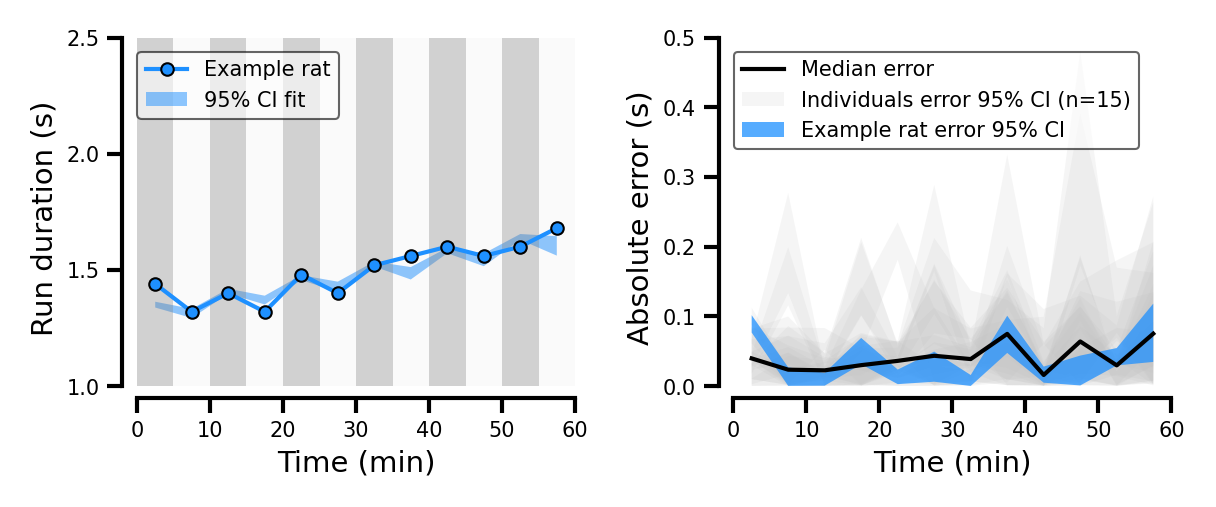

In [7]:
# compute model error crossing time

def process_error_crossing_time(n_simul=10000):
    N_bins = 6
    N_avg = 4
    _, _, _, _, _, _, _mu, _mu_t, _mu_u, _sigma, _sigma_t, _sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    error = {}

    for animal in animalList:
        print(f'Computing for {animal}')
        sessions = matchsession(animal, dist120)
        data = [[],[],[],[],[],[],[],[],[],[],[],[]]
        for i, session in enumerate(sessions):
            example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
            for j in range(0, 12):
                data[j] = np.append(data[j], example_runningTimeInLeftBin[j]+example_runningTimeInRightBin[j])
    
        ex_mu = _mu[animal]['120']
        ex_mu_t = _mu_t[animal]['120']
        ex_mu_u = _mu_u[animal]['120']
        ex_sigma = _sigma[animal]['120']
        ex_sigma_t = _sigma_t[animal]['120']
        ex_sigma_u = _sigma_u[animal]['120']


        MU = np.zeros((N_bins, N_avg))
        SIGMA = np.zeros((N_bins, N_avg))
        for bin in range(N_bins):
            for avg in range(N_avg):
                MU[bin, avg] = ex_mu + bin*ex_mu_t + avg*ex_mu_u
                SIGMA[bin, avg] = ex_sigma + bin*ex_sigma_t + avg*ex_sigma_u

        m = []
        s = []
        for i in range(6):
            m.append((.9*MU[i][0] + 0.1*MU[i][1]))
            m.append((.9*MU[i][-1] + 0.1*MU[i][-2]))
            s.append((.9*SIGMA[i][0] + 0.1*SIGMA[i][1]))
            s.append((.9*SIGMA[i][-1] + 0.1*SIGMA[i][-2]))


        error[animal] = np.zeros((n_simul, 12))
        # simuls = np.zeros((n_simul, 12))
        for _ in range(n_simul):
            res = [np.median(generate_running_time(m[i], s[i], len(data[i]), seed=_)) for i in range(len(blocks))]      
            # simuls[_] = res
            error[animal][_] = [np.sqrt((np.median(data[i]) - res[i])**2) for i in range(0, len(blocks))]
    
    return error

def FigureS4A(ax=None, n_simul=10000):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Run duration (s)")
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 2.5)
    ax.set_yticks([1, 1.5, 2, 2.5])
    space_axes(ax)


    # experimental rat data
    root = "/home/david/Desktop/ALLDATA"
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']


    sessions = matchsession(animal, dist120)
    data = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for i, session in enumerate(sessions):
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
        for j in range(0, 12):
            data[j] = np.append(data[j], example_runningTimeInLeftBin[j]+example_runningTimeInRightBin[j])

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))], marker='o', ms=3, color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')
    

    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4

    _, _, _, _, _, _, ex_mu, ex_mu_t, ex_mu_u, ex_sigma, ex_sigma_t, ex_sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    ex_mu = ex_mu[animal]['120']
    ex_mu_t = ex_mu_t[animal]['120']
    ex_mu_u = ex_mu_u[animal]['120']
    ex_sigma = ex_sigma[animal]['120']
    ex_sigma_t = ex_sigma_t[animal]['120']
    ex_sigma_u = ex_sigma_u[animal]['120']


    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))
    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = ex_mu + bin*ex_mu_t + avg*ex_mu_u
            SIGMA[bin, avg] = ex_sigma + bin*ex_sigma_t + avg*ex_sigma_u

    m = []
    s = []
    for i in range(6):
        m.append((.9*MU[i][0] + 0.1*MU[i][1]))
        m.append((.9*MU[i][-1] + 0.1*MU[i][-2]))
        s.append((.9*SIGMA[i][0] + 0.1*SIGMA[i][1]))
        s.append((.9*SIGMA[i][-1] + 0.1*SIGMA[i][-2]))


    error = np.zeros((n_simul, 12))
    simuls = np.zeros((n_simul, 12))
    for _ in range(n_simul):
        res = [np.median(generate_running_time(m[i], s[i], len(data[i]), seed=_)) for i in range(len(blocks))]      
        simuls[_] = res
        error[_] = [np.sqrt((np.median(data[i]) - res[i])**2) for i in range(0, len(blocks))]

    CI = np.percentile(simuls[:, :], [2.5, 97.5], axis=0)
    y = np.concatenate([CI[0], CI[1][::-1]])
    x = np.concatenate([[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                        [(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))][::-1]])
    ax.fill(x, y, alpha=.5, color=rat_markers[animal][0], label='95% CI fit', zorder=0, lw=0)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

def FigureS4B(error, ax=None, n_simul=10000):
    if ax is None:
        ax = plt.gca()
    
    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    median_error_per_block = {}
    for animal in intact:
        median_error_per_block[animal] = np.median(error[animal], axis=0)

        # ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
        #     [median_error_per_block[animal][i] for i in range(0, len(blocks))],
        #     color='k', ls='--', label='Example rat fit', zorder=5, lw=0.5, alpha=.5)

        CI = np.percentile(error[animal][:, :], [2.5, 97.5], axis=0)
        y = np.concatenate([CI[0], CI[1][::-1]])
        x = np.concatenate([[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                            [(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))][::-1]])
        zorder = 10 if animal == 'RatM00' else 5
        _alpha = .75 if animal == 'RatM00' else .15
        _label = 'Example rat error 95% CI' if animal == 'RatM00' else f'Individuals error 95% CI (n={len(intact)})'
        ax.fill(x, y, alpha=_alpha, color=rat_markers[animal][0], label=_label, lw=0, zorder=zorder)

    median_of_median = [np.median([median_error_per_block[animal][i] for animal in intact]) for i in range(len(blocks))]
    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [median_of_median[i] for i in range(0, len(blocks))],
            color='k', label='Median error', zorder=15, lw=1, alpha=1)
    print(median_of_median)
    print(np.median(median_of_median))

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Absolute error (s)")
    ax.set_xlim(0, 60)
    ax.set_ylim(0, .5)
    # ax.set_yticks([0, .05, .1, .15])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

n_simul = 10000
fig, axs = plt.subplots(1, 2, figsize=(cm2inch(10), cm2inch(4)))
FigureS4A(ax=axs[0], n_simul=n_simul)

if os.path.exists("picklejar/modelErrorCrossingTime10000.p"):
    error_crossing = pickle.load(open("picklejar/modelErrorCrossingTime10000.p", "rb"))
else:
    error_crossing = process_error_crossing_time(n_simul=n_simul)
    pickle.dump(error_crossing, open("picklejar/modelErrorCrossingTime10000.p", "wb"))

FigureS4B(error_crossing, ax=axs[1], n_simul=n_simul)

4.4646464646464645


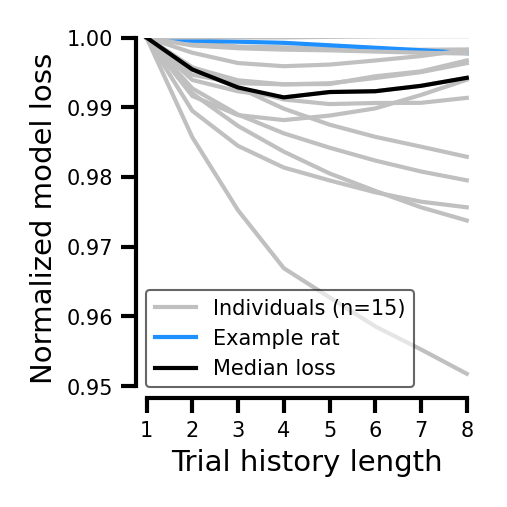

In [8]:
def historyLossesCrossingTime(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))

    memsizes = np.arange(1, 9)
    history_losses = pickle.load(open("picklejar/rewardHistoryLossCrossingTime.p", "rb"))
    normalized_history_losses = {animal: (history_losses[animal])/(history_losses[animal][0]) for animal in intact}
    median_losses = np.median(np.array(list(normalized_history_losses.values())), axis=0)


    for animal in intact:
        _label = 'Example rat' if animal == 'RatM00' else f'Individuals (n={len(intact)})'
        ax.plot(memsizes, normalized_history_losses[animal], color=rat_markers[animal][0], label=_label)

    ax.plot(memsizes, median_losses, color='k', lw=1, label='Median loss')
    z = np.poly1d(np.polyfit(memsizes, median_losses, 3))
    x=np.linspace(1, 8, 100)
    # ax.plot(x, z(x), color='k', lw=1, ls='--')
    print(x[np.argmin(z(x))])

    ax.set_xlabel('Trial history length')
    ax.set_xlim(1, 8)
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])

    ax.set_ylabel('Normalized model loss')
    ax.set_ylim(0.95, 1.0)
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='best', #bbox_to_anchor=(0.01, 0.99), 
              frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

    

historyLossesCrossingTime(ax=None)

In [9]:
def LLratio_vs_complete(ablation_losses, keys, ax=None):
    if ax is None: ax = plt.gca()
    LL_sums = [np.sum([ablation_losses[animal][key] for animal in intact]) for key in keys]
    LL_complete = LL_sums[0]
    LL_reduced = LL_sums[1:]
    dParams = [np.sum(key) for key in keys][1:]

    p_vals = np.zeros(len(dParams))
    for i, (reducted_model_loss, df) in enumerate(zip(LL_reduced, dParams)):
        LR = -2*(reducted_model_loss - LL_complete)
        p_vals[i] = stats.chi2.sf(LR, df)

    sig, corrected_pvals, alphabonf = multipletests_bonferroni(p_vals)
    for i, p_val in enumerate(corrected_pvals):
        barplot_annotate_brackets(ax, 0, i+1, p_val, np.arange(1, 7), 
                                  [-LL_complete]*6, 
                                  dh=0.15+i*.1, barh=.025, maxasterix=None)
    print(sig)
        


the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

In [10]:



pvals = [4.44e-13,0.103,0.033,0.037,1.351e-12]
print(multipletests_bonferroni(pvals))

(array([ True, False, False, False,  True]), array([2.220e-12, 5.150e-01, 1.650e-01, 1.850e-01, 6.755e-12]), 0.01)


[ True False False False  True]


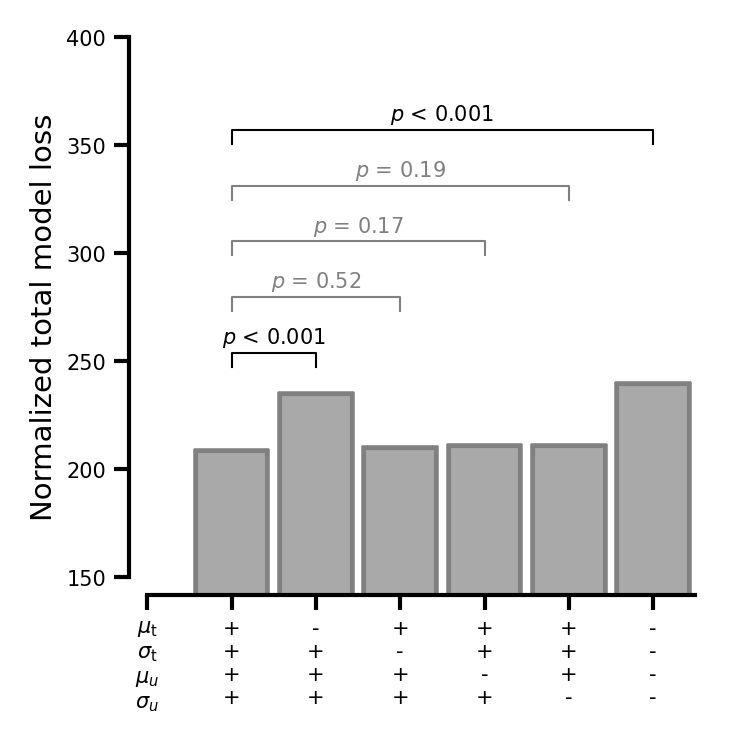

In [11]:
# likelihood ratio crossing time

def ablation_crossing_time(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(6)))

    ablation_losses = pickle.load(open("picklejar/ablationLossesCrossingTime.p", "rb"))

    for animal in intact:
        for i, key in enumerate(the_keys_i_want):
            ax.bar(i+1, -np.sum([ablation_losses[animal][key] for animal in intact]), 
                   color='gray', width=.85, facecolor='darkgray', edgecolor='gray', lw=1, zorder=1)

        ax.set_ylabel('Normalized total model loss')
        ax.set_xticks(np.arange(7))
        ax.set_xticklabels(dict_to_xticklabels({k:ablation_losses[animal][k] for k in the_keys_i_want}, labels=['$\mu_{\mathrm{t}}$', '$\sigma_{\mathrm{t}}$', '$\mu_u$', '$\sigma_u$']))
        ax.set_ylim(150, 400)
        ax.set_yticks([150, 200, 250, 300, 350, 400])
        ax.set_xlim(0, 6.5)
        ax.axhline(1, color='k', linestyle='--')
        space_axes(ax)

    LLratio_vs_complete(ablation_losses, the_keys_i_want, ax)
ablation_crossing_time(ax=None)

[0.03976230788132762, 0.023588832211405397, 0.022662718313949615, 0.030092150319564692, 0.03624353811004566, 0.04354052197265157, 0.03882230479976634, 0.07491999328933496, 0.01600152044164216, 0.06407627920695169, 0.02977281089071082, 0.07522926867713586]
0.037532921454906
4.4646464646464645
[ True False False False  True]


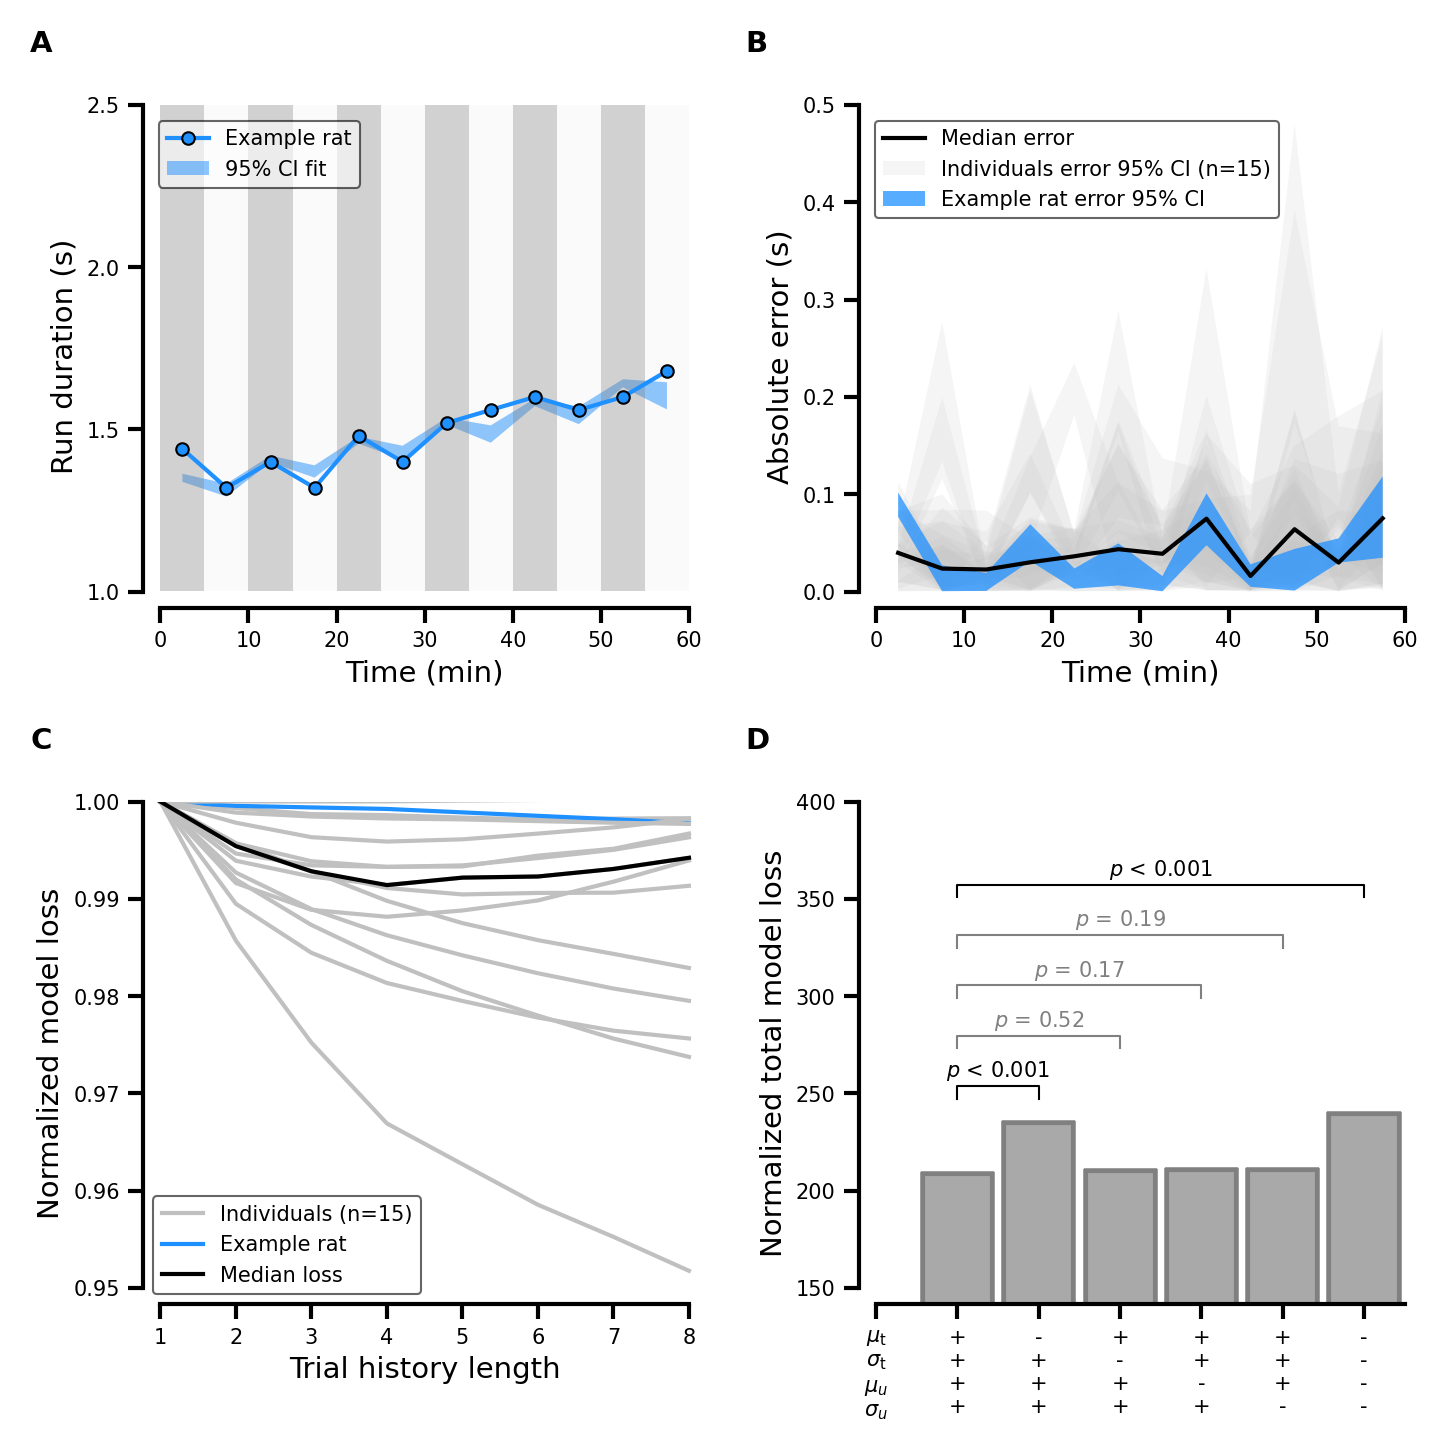

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(cm2inch(12), cm2inch(12)))

FigureS4A(ax=axs[0, 0])
FigureS4B(error_crossing, ax=axs[0, 1])
historyLossesCrossingTime(ax=axs[1, 0])
ablation_crossing_time(ax=axs[1, 1])

for ax, letter in zip(axs.flatten(), ["A", "B", "C", "D"]):
    letter_on_subplot(ax, letter, x_rel=-0.2, y_rel=1.15)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S4.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S4.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

# S1 Model idle time

[0.15092731899871326, 0.4265545769953699, 0.28871032216975845, 0.6580015924050041, 0.39156091971491214, 0.7465890645485107, 0.3874796928207356, 0.7453056439536976, 0.553557454058301, 1.4044326306965425, 0.7440381706013453, 2.327589284105646]
0.6057795232316525


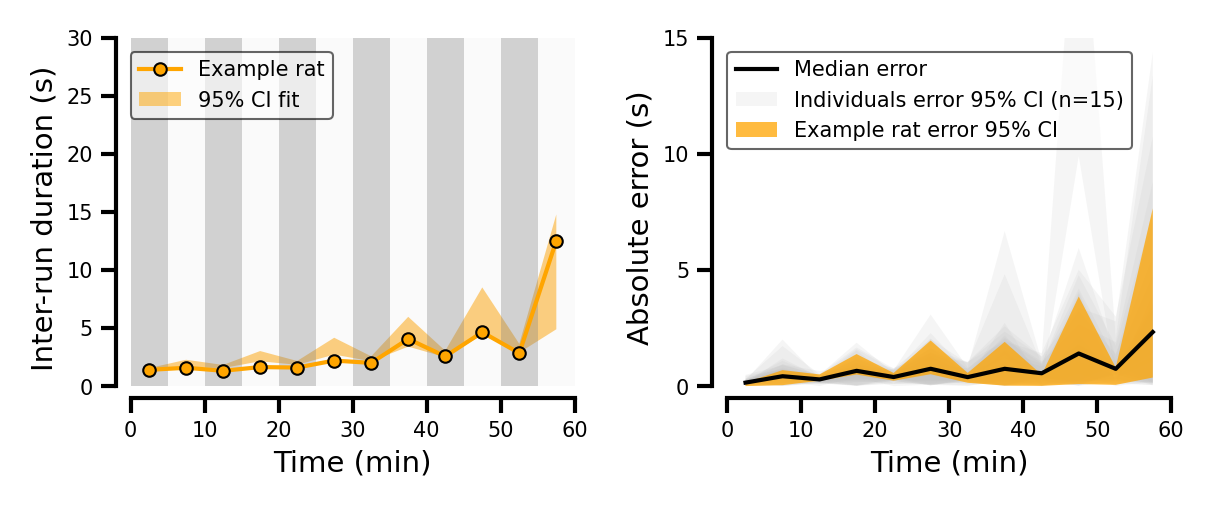

In [12]:
# compute model error crossing time

def process_error_idle_time(n_simul=10000):
    N_bins = 6
    N_avg = 4
    _alpha, _alpha_t, _alpha_u, _gamma, _gamma_t, _gamma_u, _, _, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    error = {}

    for animal in animalList:
        print(f'Computing for {animal}')
        sessions = matchsession(animal, dist120)
        data = [[],[],[],[],[],[],[],[],[],[],[],[]]
        for i, session in enumerate(sessions):
            example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
            for j in range(0, 12):
                data[j] = np.append(data[j], example_runningTimeInLeftBin[j]+example_runningTimeInRightBin[j])
    
        ex_alpha = _alpha[animal]['120']
        ex_alpha_t = _alpha_t[animal]['120']
        ex_alpha_u = _alpha_u[animal]['120']
        ex_gamma = _gamma[animal]['120']
        ex_gamma_t = _gamma_t[animal]['120']
        ex_gamma_u = _gamma_u[animal]['120']

        ALPHA = np.zeros((N_bins, N_avg))
        GAMMA = np.zeros((N_bins, N_avg))
        for bin in range(N_bins):
            for avg in range(N_avg):
                ALPHA[bin, avg] = ex_alpha + bin*ex_alpha_t + avg*ex_alpha_u
                GAMMA[bin, avg] = ex_gamma + bin*ex_gamma_t + avg*ex_gamma_u

        a = []
        g = []
        for i in range(6):
            a.append(.9*ALPHA[i][0]+0.1*ALPHA[i][1])
            a.append(.9*ALPHA[i][-1]+0.1*ALPHA[i][-2])
            g.append(.9*GAMMA[i][0]+0.1*GAMMA[i][1])
            g.append(.9*GAMMA[i][-1]+0.1*GAMMA[i][-2])


        error[animal] = np.zeros((n_simul, 12))
        for _ in range(n_simul):
            # if _ // 1000 == 0:
            #     print(f'Rat: {animal} || {_}/{n_simul}')
            res = [np.median(generate_idle_time(a[i], g[i], len(data[i]), seed=_)) for i in range(len(blocks))]   
            error[animal][_] = [np.sqrt((np.median(data[i]) - res[i])**2) for i in range(0, len(blocks))]
    
    return error

def FigureS1A(ax=None, n_simul=10000):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Inter-run duration (s)")
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    # ax.set_yticks([0, 5, 10, 15])
    space_axes(ax)


    # experimental rat data
    root = "/home/david/Desktop/ALLDATA"
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']


    sessions = matchsession(animal, dist120)
    data = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for i, session in enumerate(sessions):
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
        for j in range(0, 12):
            data[j] = np.append(data[j], example_runningTimeInLeftBin[j]+example_runningTimeInRightBin[j])

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],
            marker='o', ms=3, color='orange', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')

    

    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4

    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u, _, _, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    ex_alpha = ex_alpha[animal]['120']
    ex_alpha_t = ex_alpha_t[animal]['120']
    ex_alpha_u = ex_alpha_u[animal]['120']
    ex_gamma = ex_gamma[animal]['120']
    ex_gamma_t = ex_gamma_t[animal]['120']
    ex_gamma_u = ex_gamma_u[animal]['120']


    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))
    for bin in range(N_bins):
        for avg in range(N_avg):
            ALPHA[bin, avg] = ex_alpha + bin*ex_alpha_t + avg*ex_alpha_u
            GAMMA[bin, avg] = ex_gamma + bin*ex_gamma_t + avg*ex_gamma_u

    a = []
    g = []
    for i in range(6):
        a.append(.9*ALPHA[i][0]+0.1*ALPHA[i][1])
        a.append(.9*ALPHA[i][-1]+0.1*ALPHA[i][-2])
        g.append(.9*GAMMA[i][0]+0.1*GAMMA[i][1])
        g.append(.9*GAMMA[i][-1]+0.1*GAMMA[i][-2])


    # error = np.zeros((n_simul, 12))
    if os.path.exists("picklejar/modelSimulIdleTime10000.p"):
        simuls = pickle.load(open("picklejar/modelSimulIdleTime10000.p", "rb"))
    else:
        simuls = np.zeros((n_simul, 12))
        for _ in range(n_simul):
            if _ / 100 == 0:
                print(f'{_}/{n_simul}')
            res = [np.median(generate_idle_time(a[i], g[i], len(data[i]), seed=_)) for i in range(len(blocks))]
            simuls[_] = res
            # error[_] = [np.sqrt((np.median(data[i]) - res[i])**2) for i in range(0, len(blocks))]
            pickle.dump(simuls, open("picklejar/modelSimulIdleTime10000.p", "wb"))

    CI = np.percentile(simuls[:, :], [2.5, 97.5], axis=0)
    y = np.concatenate([CI[0], CI[1][::-1]])
    x = np.concatenate([[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                        [(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))][::-1]])
    ax.fill(x, y, alpha=.5, color='orange', label='95% CI fit', zorder=0, lw=0)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

def FigureS1B(error, ax=None, n_simul=10000):
    if ax is None:
        ax = plt.gca()
    
    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    median_error_per_block = {}
    for animal in intact:
        median_error_per_block[animal] = np.median(error[animal], axis=0)

        CI = np.percentile(error[animal][:, :], [2.5, 97.5], axis=0)
        y = np.concatenate([CI[0], CI[1][::-1]])
        x = np.concatenate([[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                            [(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))][::-1]])
        zorder = 10 if animal == 'RatM00' else 5
        _alpha = .75 if animal == 'RatM00' else .15
        _label = 'Example rat error 95% CI' if animal == 'RatM00' else f'Individuals error 95% CI (n={len(intact)})'
        _color = 'orange' if animal == 'RatM00' else rat_markers[animal][0]
        ax.fill(x, y, alpha=_alpha, color=_color, label=_label, lw=0, zorder=zorder)

    median_of_median = [np.median([median_error_per_block[animal][i] for animal in intact]) for i in range(len(blocks))]
    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [median_of_median[i] for i in range(0, len(blocks))],
            color='k', label='Median error', zorder=15, lw=1, alpha=1)
    print(median_of_median)
    print(np.median(median_of_median))

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Absolute error (s)")
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 15)
    ax.set_yticks([0, 5, 10, 15])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


n_simul = 10000
fig, axs = plt.subplots(1, 2, figsize=(cm2inch(10), cm2inch(4)))
FigureS1A(ax=axs[0], n_simul=n_simul)

if os.path.exists("picklejar/modelErrorIdleTime10000.p"):
    error_idle = pickle.load(open("picklejar/modelErrorIdleTime10000.p", "rb"))
else:
    error_idle = process_error_idle_time(n_simul=n_simul)  # 530 minutes for 10000 simulations * 28 rats
    pickle.dump(error_idle, open("picklejar/modelErrorIdleTime10000.p", "wb"))

FigureS1B(error_idle, ax=axs[1], n_simul=n_simul)

3.4747474747474745


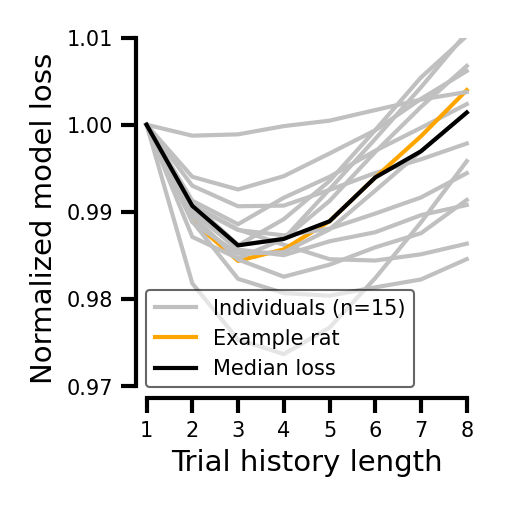

In [14]:
def historyLossesIdleTime(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))

    memsizes = np.arange(1, 9)
    history_losses = pickle.load(open("picklejar/rewardHistoryLossIdleTime.p", "rb"))
    normalized_history_losses = {animal: (history_losses[animal])/(history_losses[animal][0]) for animal in intact}
    median_losses = np.median(np.array(list(normalized_history_losses.values())), axis=0)


    for animal in intact:
        _label = 'Example rat' if animal == 'RatM00' else f'Individuals (n={len(intact)})'
        _color = 'orange' if animal == 'RatM00' else rat_markers[animal][0]
        ax.plot(memsizes, normalized_history_losses[animal], color=_color, label=_label)

    ax.plot(memsizes, median_losses, color='k', lw=1, label='Median loss')
    z = np.poly1d(np.polyfit(memsizes, median_losses, 3))
    x=np.linspace(1, 8, 100)
    # ax.plot(x, z(x), color='k', lw=1, ls='--')
    print(x[np.argmin(z(x))])

    ax.set_xlabel('Trial history length')
    ax.set_xlim(1, 8)
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])

    ax.set_ylabel('Normalized model loss')
    ax.set_ylim(0.97, 1.01)
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='best', #bbox_to_anchor=(0.01, 0.99), 
              frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

historyLossesIdleTime(ax=None)

[ True  True False  True  True]


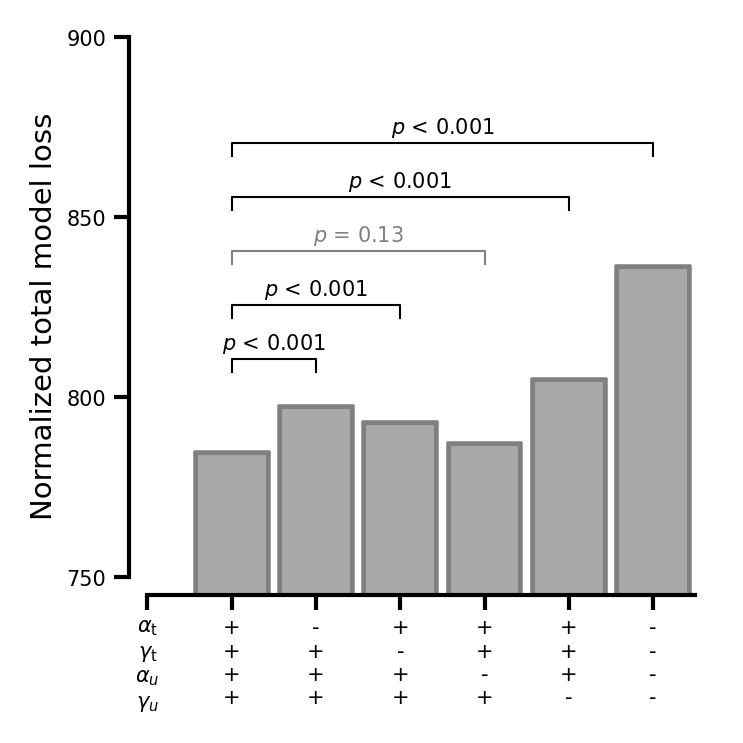

In [15]:
# likelihood ratio idle time
def ablation_idle_time(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(6)))

    ablation_losses = pickle.load(open("picklejar/ablationLossesIdleTime.p", "rb"))
    for animal in intact:
        for i, key in enumerate(the_keys_i_want):
            ax.bar(i+1, -np.sum([ablation_losses[animal][key] for animal in intact]), 
                   color='gray', width=.85, facecolor='darkgray', edgecolor='gray', lw=1, zorder=1)

        ax.set_ylabel('Normalized total model loss')
        ax.set_xticks(np.arange(7))
        ax.set_xticklabels(dict_to_xticklabels({k:ablation_losses[animal][k] for k in the_keys_i_want}, 
                                               labels=['$\\alpha_{\mathrm{t}}$', '$\\gamma_{\mathrm{t}}$', '$\\alpha_u$', '$\\gamma_u$']))
        ax.set_ylim(750, 900)
        ax.set_yticks([750, 800, 850, 900])
        ax.set_xlim([0, 6.5])
        ax.axhline(1, color='k', linestyle='--')

    LLratio_vs_complete(ablation_losses, the_keys_i_want, ax)
    space_axes(ax)

ablation_idle_time(ax=None)

[0.15092731899871326, 0.4265545769953699, 0.28871032216975845, 0.6580015924050041, 0.39156091971491214, 0.7465890645485107, 0.3874796928207356, 0.7453056439536976, 0.553557454058301, 1.4044326306965425, 0.7440381706013453, 2.327589284105646]
0.6057795232316525
3.4747474747474745
[ True  True False  True  True]


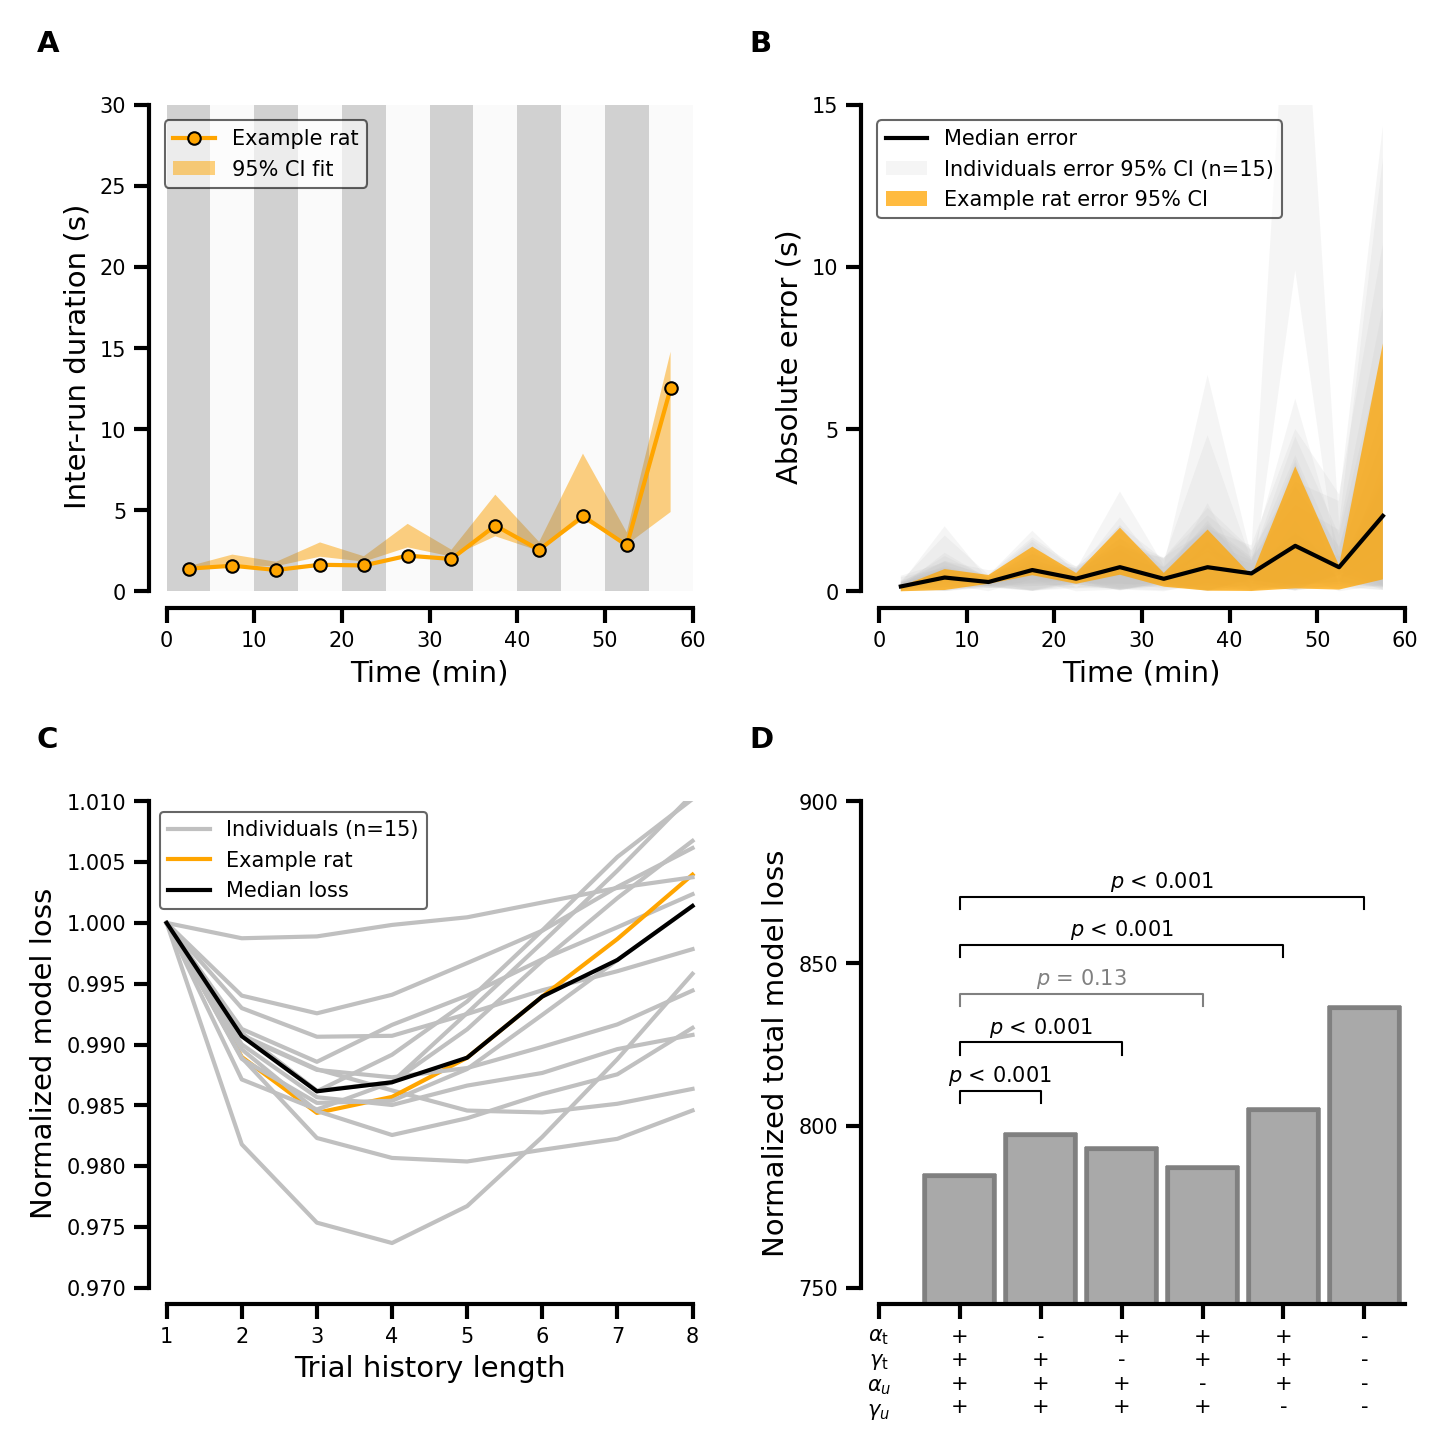

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(cm2inch(12), cm2inch(12)))

FigureS1A(ax=axs[0, 0])
FigureS1B(error_idle, ax=axs[0, 1])
historyLossesIdleTime(ax=axs[1, 0])
ablation_idle_time(ax=axs[1, 1])

for ax, letter in zip(axs.flatten(), ["A", "B", "C", "D"]):
    letter_on_subplot(ax, letter, x_rel=-0.2, y_rel=1.15)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S1.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S1.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

# s5 $\sigma$

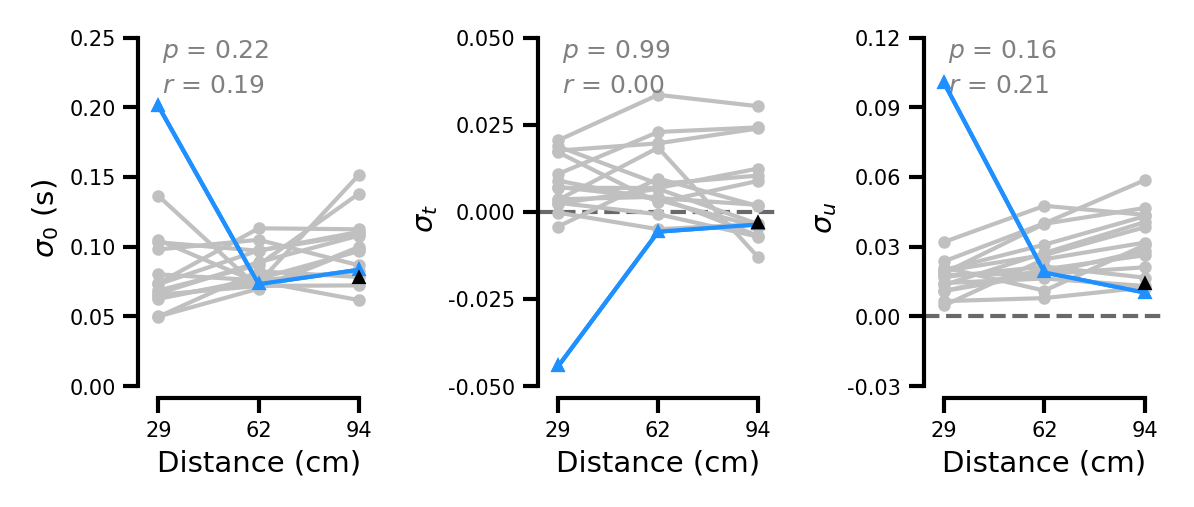

In [34]:
def FigureS5AL(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))


    _, _, _, _, _, _, _, _, _, sigma_0, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in intact:
        ax.plot([0, 1, 2], [sigma_0[animal]["60"], sigma_0[animal]["90"], sigma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [sigma_0[animal]["60"], sigma_0[animal]["90"], sigma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5)

    
    ex_mu, ex_mu_t, ex_mu_u, ex_sigma, ex_sigma_t, ex_sigma_u = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_sigma, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, .25)
    ax.set_yticks([0, .05, .1, .15, .2, .25])
    ax.set_ylabel(r'$\sigma_0$' + ' (s)')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

    # permutation_test_distances(sigma_0, ax=ax, h='top', num_permutations=10000)
    r, p_value = regression_permutation(sigma_0, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)
    
        
def FigureS5AM(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, _, sigma_t, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in intact:
        ax.plot([0, 1, 2], [sigma_t[animal]["60"], sigma_t[animal]["90"], sigma_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2], [sigma_t[animal]["60"], sigma_t[animal]["90"], sigma_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ex_mu, ex_mu_t, ex_mu_u, ex_sigma, ex_sigma_t, ex_sigma_u = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_sigma_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.05, .05)
    ax.set_yticks([-.05, -.025, 0, .025, 0.05])
    ax.set_ylabel(r'$\sigma_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(sigma_t, ax=ax, h='top', num_permutations=10000)
    r, p_value = regression_permutation(sigma_t, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)

def FigureS5AR(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, _, _, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in intact:
        ax.plot([0, 1, 2], [sigma_u[animal]["60"], sigma_u[animal]["90"], sigma_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [sigma_u[animal]["60"], sigma_u[animal]["90"], sigma_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ex_mu, ex_mu_t, ex_mu_u, ex_sigma, ex_sigma_t, ex_sigma_u = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_sigma_u, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.03, .12)
    ax.set_yticks([-.03, 0, .03, .06, .09, .12])
    ax.set_ylabel(r'$\sigma_u$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(sigma_u, ax=ax, h='top', num_permutations=10000)
    r, p_value = regression_permutation(sigma_u, dist_or_tm='dist')
    annotate_regression(p_value, r, ax)
    
fig, axs = plt.subplots(1, 3, figsize=(cm2inch(18)*6/11, cm2inch(4)), dpi=300)
FigureS5AL(ax=axs[0])
FigureS5AM(ax=axs[1])
FigureS5AR(ax=axs[2])

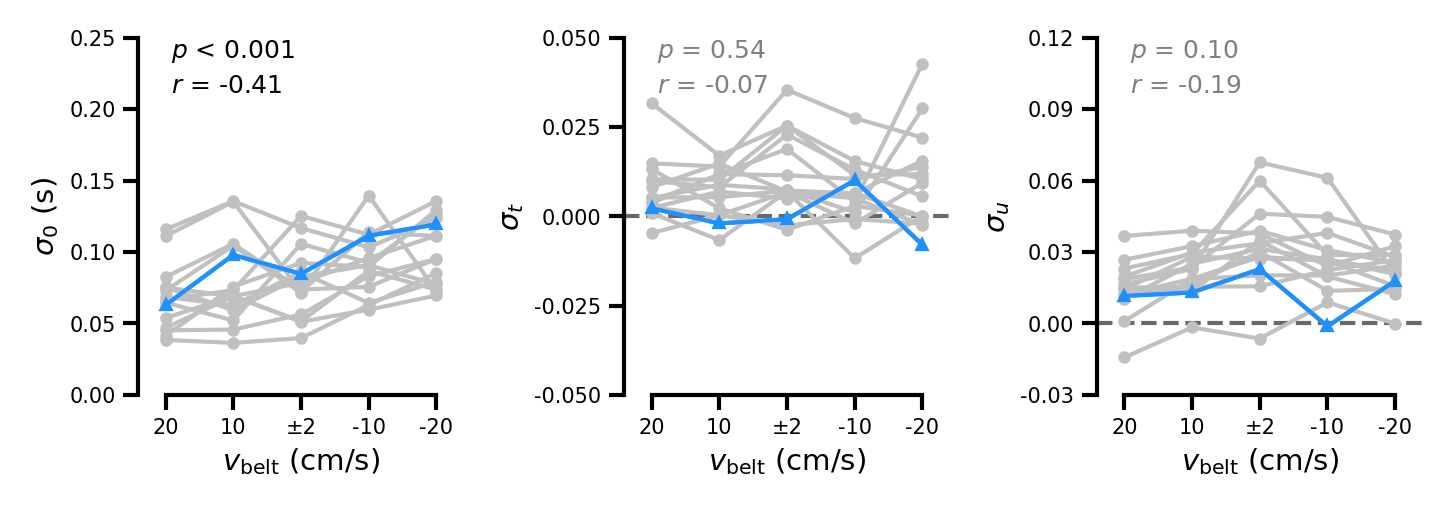

In [35]:
def FigureS5BL(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, sigma_0, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in intact:
        ax.plot([0, 1, 2, 3, 4], [sigma_0[animal]["20"], sigma_0[animal]["10"], sigma_0[animal]["2"], sigma_0[animal]["rev10"], sigma_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
    
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [sigma_0[animal]["20"], sigma_0[animal]["10"], sigma_0[animal]["2"], sigma_0[animal]["rev10"], sigma_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, .25)
    ax.set_yticks([0, .05, .1, .15, .2, .25])
    ax.set_ylabel(r'$\sigma_0$' + ' (s)')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(sigma_0, ax=ax, num_permutations=10000)
    r, p_value = regression_permutation(sigma_0, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)

def FigureS5BM(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, _, sigma_t, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in intact:
        ax.plot([0, 1, 2, 3, 4], [sigma_t[animal]["20"], sigma_t[animal]["10"], sigma_t[animal]["2"], sigma_t[animal]["rev10"], sigma_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [sigma_t[animal]["20"], sigma_t[animal]["10"], sigma_t[animal]["2"], sigma_t[animal]["rev10"], sigma_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.05, .05)
    ax.set_yticks([-.05, -.025, 0, .025, 0.05])
    ax.set_ylabel(r'$\sigma_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(sigma_t, ax=ax, num_permutations=10000)
    r, p_value = regression_permutation(sigma_t, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)

def FigureS5BR(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, _, _, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in intact:
        ax.plot([0, 1, 2, 3, 4], [sigma_u[animal]["20"], sigma_u[animal]["10"], sigma_u[animal]["2"], sigma_u[animal]["rev10"], sigma_u[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [sigma_u[animal]["20"], sigma_u[animal]["10"], sigma_u[animal]["2"], sigma_u[animal]["rev10"], sigma_u[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-.03, .12)
    ax.set_yticks([-.03, 0, .03, .06, .09, .12])
    ax.set_ylabel(r'$\sigma_u$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(sigma_u, ax=ax, num_permutations=10000)
    r, p_value = regression_permutation(sigma_u, dist_or_tm='tm')
    annotate_regression(p_value, r, ax)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
FigureS5BL(ax=axs[0])
FigureS5BM(ax=axs[1])
FigureS5BR(ax=axs[2])

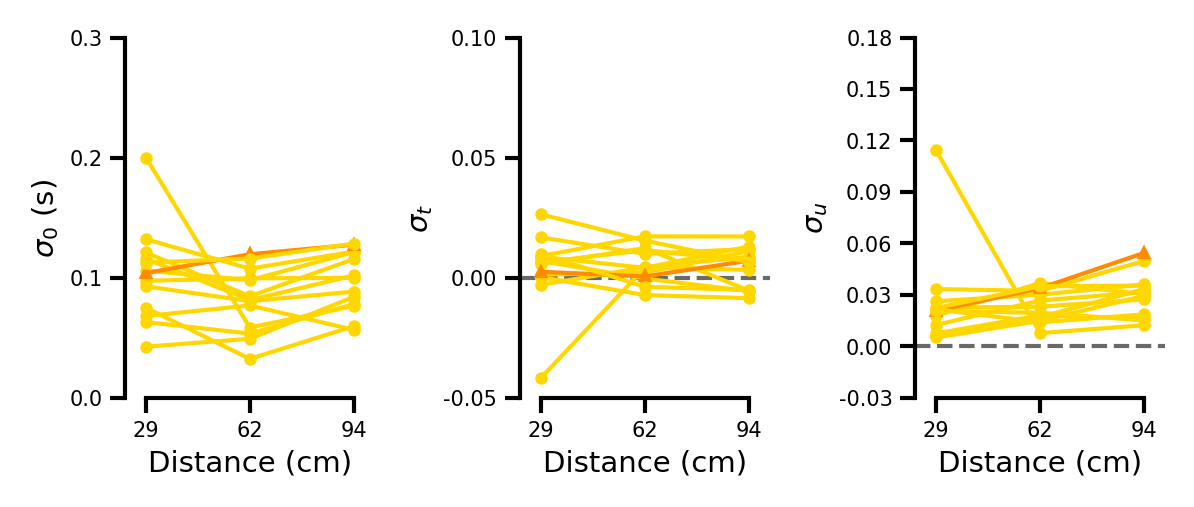

In [37]:
def Figure2F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))


    _, _, _, _, _, _, _, _, _, sigma_0, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in lesioned:
        ax.plot([0, 1, 2], [sigma_0[animal]["60"], sigma_0[animal]["90"], sigma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, .3)
    ax.set_yticks([0, .1, .2, .3])
    ax.set_ylabel(r'$\sigma_0$' + ' (s)')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

    # permutation_test_distances(sigma_0, ax=ax, h='top', num_permutations=10000, animals=lesioned)
    
        
def Figure2G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, _, sigma_t, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in lesioned:
        ax.plot([0, 1, 2], [sigma_t[animal]["60"], sigma_t[animal]["90"], sigma_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.05, .1)
    ax.set_yticks([-.05, 0, 0.05, .1,])
    ax.set_ylabel(r'$\sigma_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(sigma_t, ax=ax, h='top', num_permutations=10000, animals=lesioned)


def Figure2H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, _, _, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in lesioned:
        ax.plot([0, 1, 2], [sigma_u[animal]["60"], sigma_u[animal]["90"], sigma_u[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.03, .18)
    ax.set_yticks([-.03, 0, .03, .06, .09, .12, .15, .18])
    ax.set_ylabel(r'$\sigma_u$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_distances(sigma_u, ax=ax, h='top', num_permutations=10000, animals=lesioned)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(18)*6/11, cm2inch(4)), dpi=300)
Figure2F(axs[0])
Figure2G(axs[1])
Figure2H(axs[2])

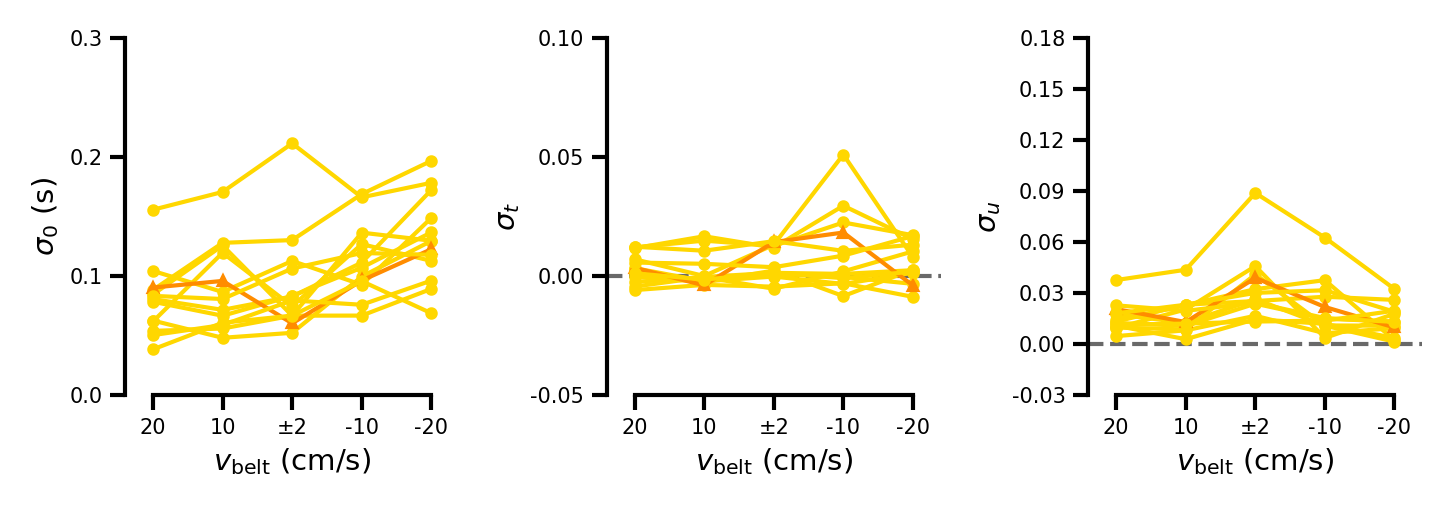

In [38]:
def Figure2K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, sigma_0, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in lesioned:
        ax.plot([0, 1, 2, 3, 4], [sigma_0[animal]["20"], sigma_0[animal]["10"], sigma_0[animal]["2"], sigma_0[animal]["rev10"], sigma_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, .3)
    ax.set_yticks([0, .1, .2, .3])
    ax.set_ylabel(r'$\sigma_0$' + ' (s)')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(sigma_0, ax=ax, num_permutations=10000, animals=lesioned)


def Figure2L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, _, sigma_t, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in lesioned:
        ax.plot([0, 1, 2, 3, 4], [sigma_t[animal]["20"], sigma_t[animal]["10"], sigma_t[animal]["2"], sigma_t[animal]["rev10"], sigma_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.05, .1)
    ax.set_yticks([-.05, 0, 0.05, .1,])
    ax.set_ylabel(r'$\sigma_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(sigma_t, ax=ax, shifty=0.2, num_permutations=10000, animals=lesioned)


def Figure2M(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, _, _, _, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in lesioned:
        ax.plot([0, 1, 2, 3, 4], [sigma_u[animal]["20"], sigma_u[animal]["10"], sigma_u[animal]["2"], sigma_u[animal]["rev10"], sigma_u[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-.03, .18)
    ax.set_yticks([-.03, 0, .03, .06, .09, .12, .15, .18])
    ax.set_ylabel(r'$\sigma_u$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    # permutation_test_vbelt(sigma_u, ax=ax, num_permutations=10000, animals=lesioned)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
Figure2K(axs[0])
Figure2L(axs[1])
Figure2M(axs[2])

$\sigma_0$ 0.0949
$\sigma_t$ 0.4927
$\sigma_u$ 0.6046


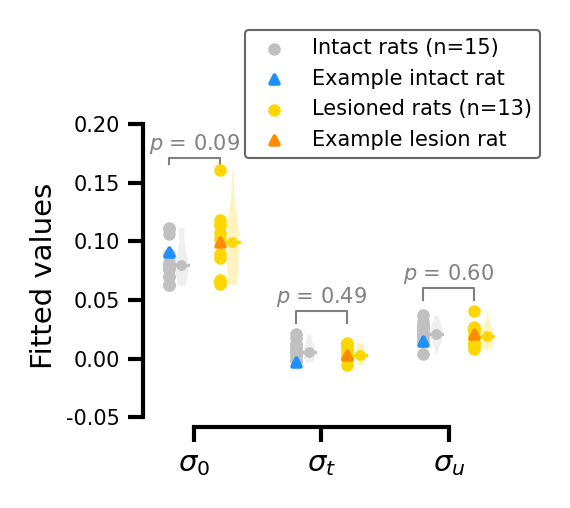

In [39]:
def FigureS5C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

    vars = [#epsilon_0, epsilon_t, epsilon_u,
            # median_alpha_0, median_alpha_t, median_alpha_u, 
            # median_gamma_0, median_gamma_t, median_gamma_u, 
            # median_mu_0, median_mu_t, median_mu_u, 
            median_sigma_0, median_sigma_t, median_sigma_u
            ]

    labels = [#r'$\epsilon_0$', r"$\epsilon_t$", r"$\epsilon_u$"
            #r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_u$", 
              #r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$", 
            #   r'$\mu_0$', r"$\mu_t$", r"$\mu_u$", 
              r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_u$"
              ]

    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in animalList:
            if brainstatus[animal] == 'normal':
                intact.append(var[animal])
                x = i - .2
                _label = 'Example intact rat' if animal == 'RatM00' else f'Intact rats (n=15)'
            else:
                lesion.append(var[animal])
                x = i + .2
                _label = 'Example lesion rat' if animal == 'RatF52' else f'Lesioned rats (n=13)'

            ax.scatter(x, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, 
                       zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5,
                          label=_label) 


        violin_parts = ax.violinplot(positions=[i-.1], 
                        dataset=[intact],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], 
                color='silver', lw=.75, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='silver', s=2.5, zorder=3)
        

        violin_parts = ax.violinplot(positions=[i+.3], 
                        dataset=[lesion],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('gold')
            vp.set_edgecolor('gold')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)
            
        ax.plot([i+.3-s, i+.3+s], [np.median(lesion), np.median(lesion)], 
                color='gold', lw=.75, zorder=2)
        ax.scatter(i+.3, np.median(lesion), color='gold', s=2.5, zorder=3)

        perm = exact_mc_perm_test(intact, lesion)
        print(label, perm)
        barplot_annotate_brackets(ax, 0, 1, perm, [i-.2, i+.2], [np.max(intact), np.max(lesion)], maxasterix=None)
    
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(-.05, .2)
    ax.set_yticks([-.05, 0, 0.05, .1, .15, .2])
    ax.set_ylabel("Fitted values")
    ax.set_xlim(0, 2)
    space_axes(ax, x_ratio_left=.2, x_ratio_right=.2)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='center', bbox_to_anchor=(.7, 1.1), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



fig, axs = plt.subplots(1, 1, figsize=(cm2inch(18/4), cm2inch(8/2)))
FigureS5C(ax=axs);

$\sigma_0$ 0.0948
$\sigma_t$ 0.4982
$\sigma_u$ 0.6032


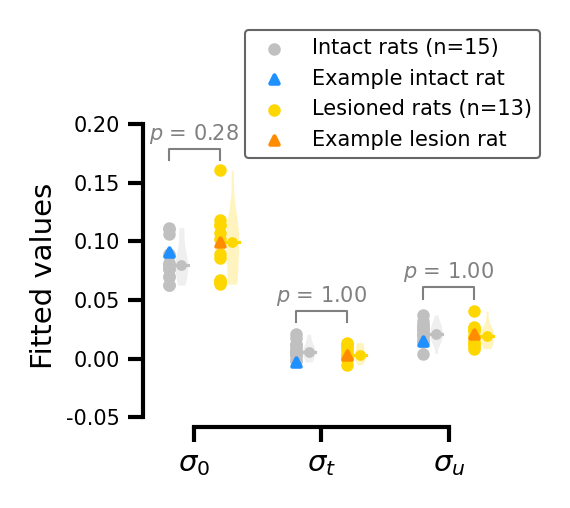

In [40]:
# bonferroni
def FigureS5C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

    vars = [#epsilon_0, epsilon_t, epsilon_u,
            # median_alpha_0, median_alpha_t, median_alpha_u, 
            # median_gamma_0, median_gamma_t, median_gamma_u, 
            # median_mu_0, median_mu_t, median_mu_u, 
            median_sigma_0, median_sigma_t, median_sigma_u
            ]

    labels = [#r'$\epsilon_0$', r"$\epsilon_t$", r"$\epsilon_u$"
            #r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_u$", 
              #r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$", 
            #   r'$\mu_0$', r"$\mu_t$", r"$\mu_u$", 
              r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_u$"
              ]

    pvalues = []
    max = []
    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in animalList:
            if brainstatus[animal] == 'normal':
                intact.append(var[animal])
                x = i - .2
                _label = 'Example intact rat' if animal == 'RatM00' else f'Intact rats (n=15)'
            else:
                lesion.append(var[animal])
                x = i + .2
                _label = 'Example lesion rat' if animal == 'RatF52' else f'Lesioned rats (n=13)'

            ax.scatter(x, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, 
                       zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5,
                          label=_label) 


        violin_parts = ax.violinplot(positions=[i-.1], 
                        dataset=[intact],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], 
                color='silver', lw=.75, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='silver', s=2.5, zorder=3)
        

        violin_parts = ax.violinplot(positions=[i+.3], 
                        dataset=[lesion],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('gold')
            vp.set_edgecolor('gold')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)
            
        ax.plot([i+.3-s, i+.3+s], [np.median(lesion), np.median(lesion)], 
                color='gold', lw=.75, zorder=2)
        ax.scatter(i+.3, np.median(lesion), color='gold', s=2.5, zorder=3)

        perm = exact_mc_perm_test(intact, lesion)
        pvalues.append(perm)
        max.append((np.max(intact), np.max(lesion)))
        print(label, perm)
        
    sig, corrected_pvalues, alphabonf = multipletests_bonferroni(pvalues, )
    for i, perm in enumerate(corrected_pvalues):
        barplot_annotate_brackets(ax, 0, 1, perm, [i-.2, i+.2], [max[i][0], max[i][1]], maxasterix=None)
        
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(-.05, .2)
    ax.set_yticks([-.05, 0, 0.05, .1, .15, .2])
    ax.set_ylabel("Fitted values")
    ax.set_xlim(0, 2)
    space_axes(ax, x_ratio_left=.2, x_ratio_right=.2)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='center', bbox_to_anchor=(.7, 1.1), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



fig, axs = plt.subplots(1, 1, figsize=(cm2inch(18/4), cm2inch(8/2)))
FigureS5C(ax=axs);

$\sigma_0$ 0.0919
$\sigma_t$ 0.5011
$\sigma_u$ 0.6095


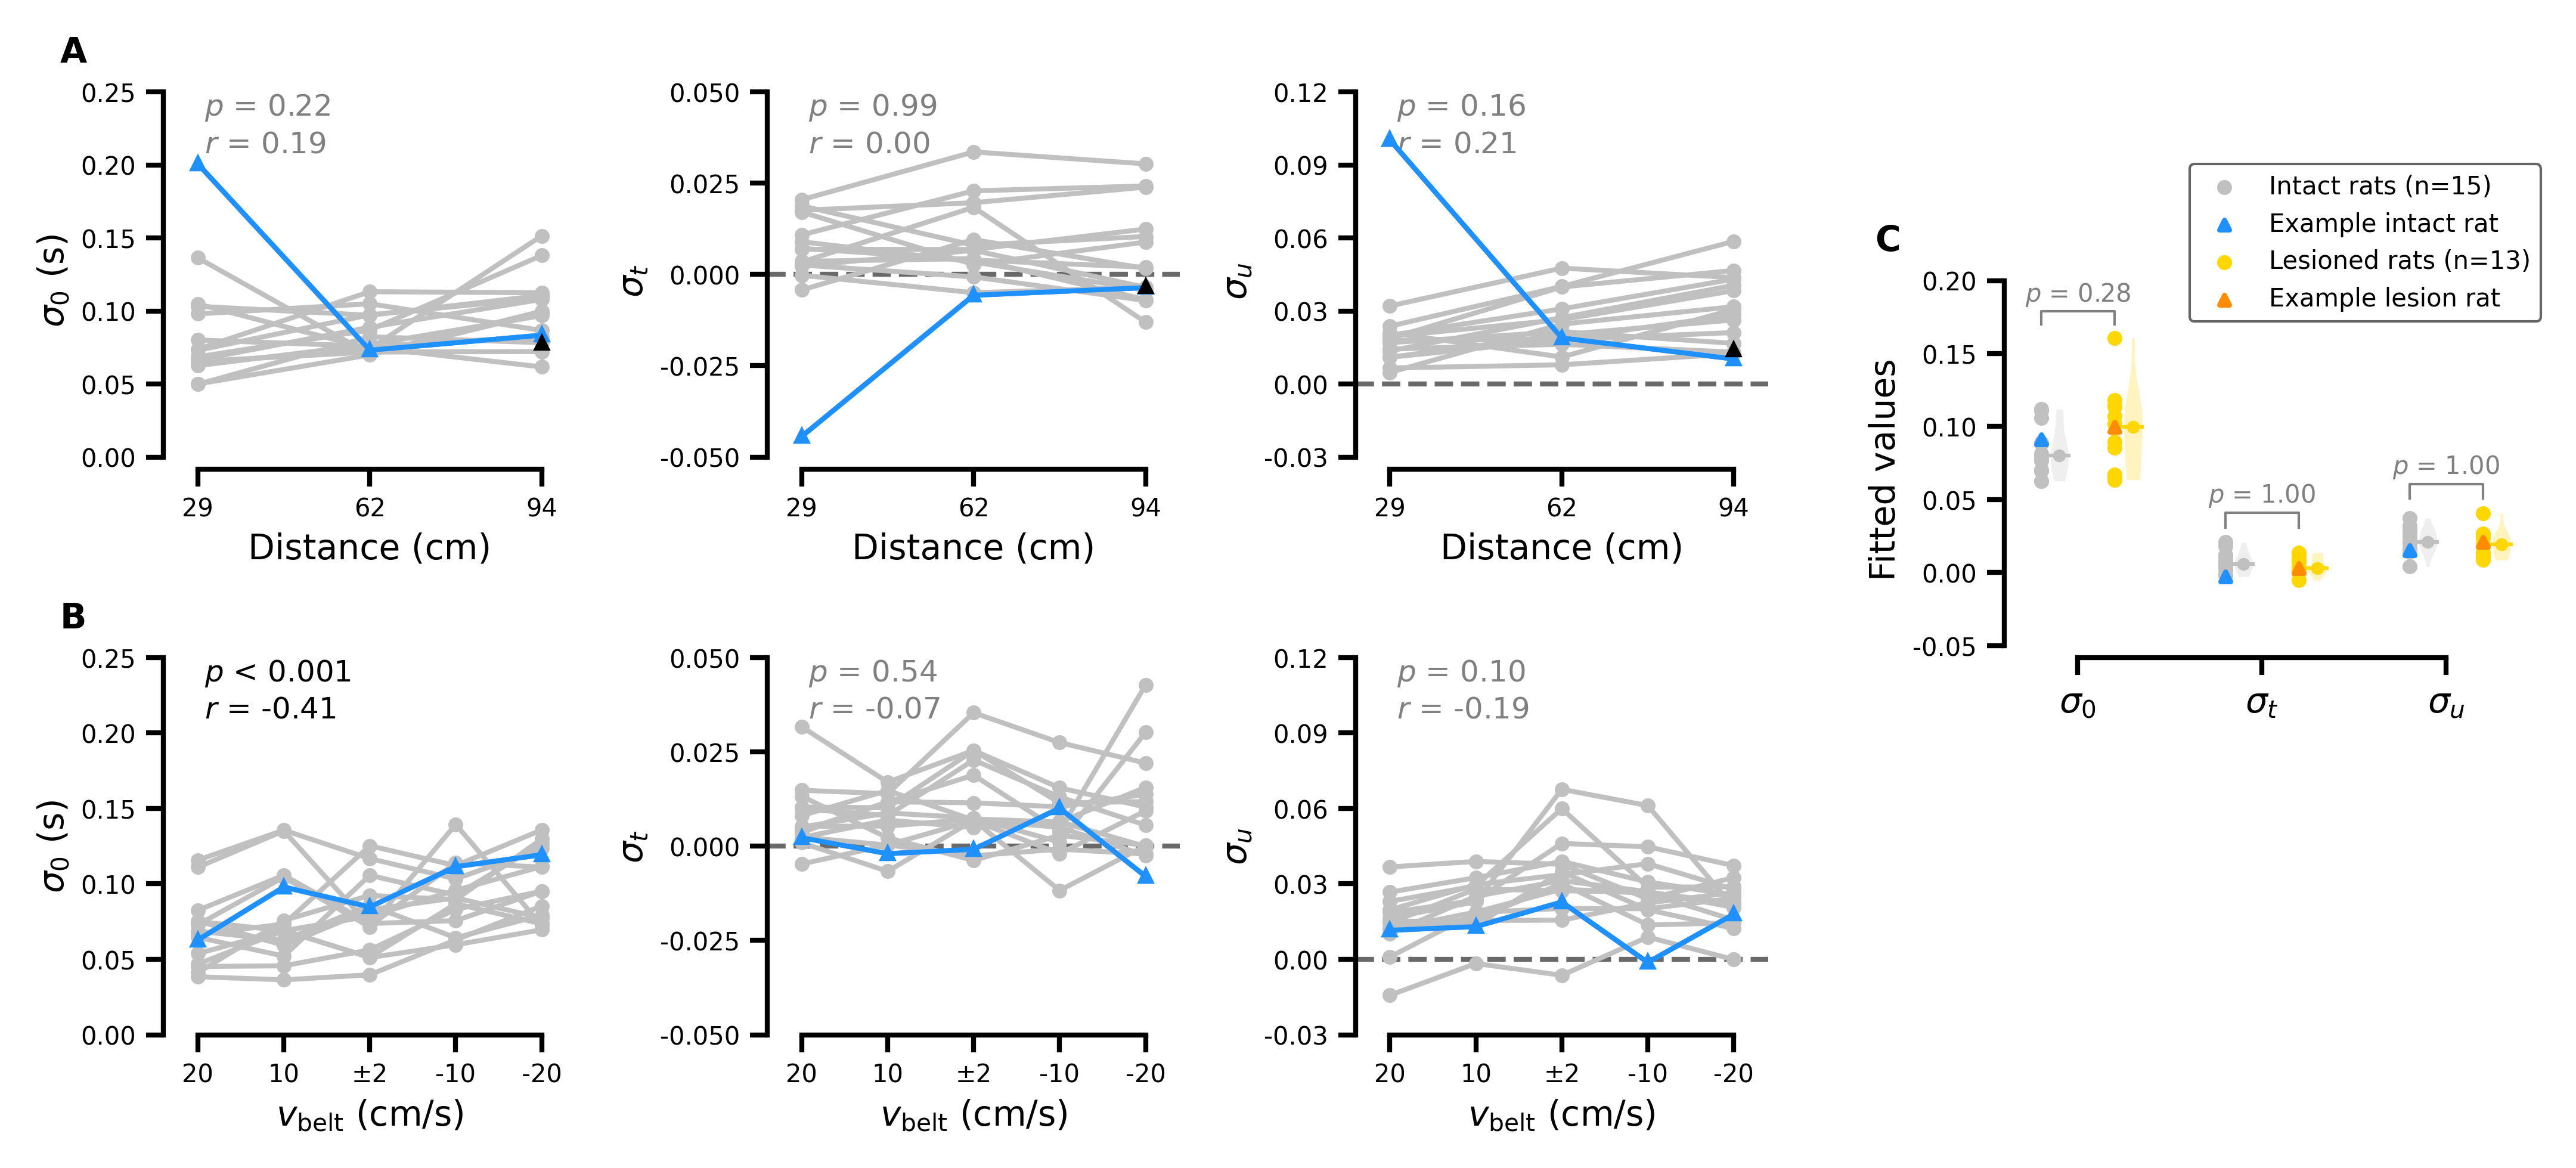

In [41]:
fig = plt.figure(figsize=(cm2inch(18), cm2inch(8)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(4, 5, wspace=.5, hspace=.5, 
                       height_ratios=[1, 1, 1, 1], width_ratios=[2, 2, 2, .1, 2.5])


fit_sigma_0_distance = plt.subplot(gs0[:2, 0])
fit_sigma_t_distance = plt.subplot(gs0[:2, 1])
fit_sigma_r_distance = plt.subplot(gs0[:2, 2])
fit_sigma_0_vbelt = plt.subplot(gs0[2:, 0])
fit_sigma_t_vbelt = plt.subplot(gs0[2:, 1])
fit_sigma_u_vbelt = plt.subplot(gs0[2:, 2])
comparison = plt.subplot(gs0[1:3, 4])

FigureS5AL(ax=fit_sigma_0_distance)
FigureS5AM(ax=fit_sigma_t_distance)
FigureS5AR(ax=fit_sigma_r_distance)
FigureS5BL(ax=fit_sigma_0_vbelt)
FigureS5BM(ax=fit_sigma_t_vbelt)
FigureS5BR(ax=fit_sigma_u_vbelt)
FigureS5C(ax=comparison)

for ax, letter in zip([fit_sigma_0_distance, fit_sigma_0_vbelt, comparison], ["A", "B", "C"]):
    letter_on_subplot(ax, letter, x_rel=-0.25, y_rel=1.15)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S5.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_S5.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)